In [1]:
# this is MuZero!
# https://arxiv.org/abs/1911.08265
# It works, but only for CartPole
# Would be happy if it worked for Follower, LunarLander, or Acrobot
# Also, while it's written, it's not using mcts.
# Replace naive_search(which tries n**K) with mcts_search to use

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os,sys
sys.path.append(os.getcwd())

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Make Follower work! Will give interview to anyone who does.
from muzero.follower import Follower
#env = Follower()
env = gym.make("CartPole-v0")
#env = gym.make("MountainCar-v0")
#env = gym.make("LunarLander-v2")
#env = gym.make("Acrobot-v1")

from muzero.model import MuModel
m = MuModel(env.observation_space.shape, env.action_space.n, s_dim=128, K=3, lr=0.001)
print(env.observation_space.shape, env.action_space.n)

from muzero.game import Game, ReplayBuffer
from muzero.mcts import naive_search, mcts_search
replay_buffer = ReplayBuffer(50, 128, m.K)
rews = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(4,) 2


In [4]:
def play_game(env, m):
  import random
  game = Game(env, discount=0.997)
  while not game.terminal():
    game.env.render()
    cc = random.random()
    if cc < 0.05:
      policy = [1/m.a_dim]*m.a_dim
    else:
      policy = naive_search(m, game.observation, T=1)
    game.act_with_policy(policy)
  return game

In [5]:
from muzero.model import reformat_batch
import collections

for j in range(30):
  game = play_game(env, m)
  replay_buffer.save_game(game)
  for i in range(20):
    m.train_on_batch(replay_buffer.sample_batch())
  rew = sum(game.rewards)
  rews.append(rew)
  print(len(game.history), rew, collections.Counter(game.history), m.losses[-1][0])

23 23.0 Counter({0: 14, 1: 9}) 128.5736
20 20.0 Counter({1: 12, 0: 8}) 113.78615
13 13.0 Counter({1: 8, 0: 5}) 75.50859
11 11.0 Counter({1: 9, 0: 2}) 57.99225
44 44.0 Counter({1: 26, 0: 18}) 119.97248
34 34.0 Counter({1: 18, 0: 16}) 151.21297
114 114.0 Counter({1: 61, 0: 53}) 789.54663
150 150.0 Counter({1: 81, 0: 69}) 1725.4662
49 49.0 Counter({0: 25, 1: 24}) 1318.1588
200 200.0 Counter({1: 104, 0: 96}) 2610.6458
200 200.0 Counter({1: 101, 0: 99}) 2981.4766
200 200.0 Counter({1: 101, 0: 99}) 4241.2534
200 200.0 Counter({1: 101, 0: 99}) 4795.629
42 42.0 Counter({1: 22, 0: 20}) 3626.3284
200 200.0 Counter({0: 100, 1: 100}) 4238.212
200 200.0 Counter({1: 101, 0: 99}) 4312.9565
200 200.0 Counter({0: 100, 1: 100}) 4798.4478
200 200.0 Counter({1: 102, 0: 98}) 4137.2915
200 200.0 Counter({0: 100, 1: 100}) 5205.156
200 200.0 Counter({1: 102, 0: 98}) 5739.6787
200 200.0 Counter({1: 101, 0: 99}) 5956.7236
200 200.0 Counter({1: 101, 0: 99}) 5686.8154
200 200.0 Counter({1: 101, 0: 99}) 6297.3506


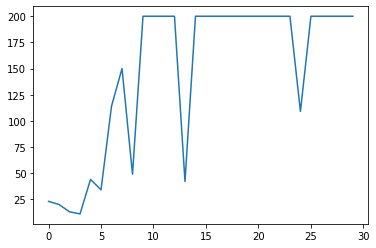

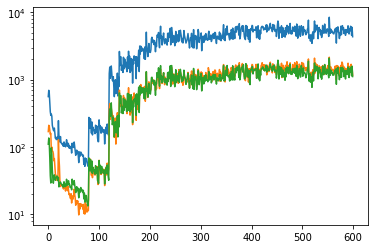

In [6]:
plot(rews)
figure()
plt.yscale('log')
plot([x[0] for x in m.losses])
plot([x[1] for x in m.losses])
plot([x[-3] for x in m.losses])

In [7]:
# can act?
state = env.reset()
for sn in range(2000):
  p_0 = naive_search(m, state, debug=False, T=0.1)
  #p_0, _ = mcts_search(m, state, 50)
  a_1 = np.random.choice(list(range(len(p_0))), p=p_0)
  _, v_0 = m.ft(m.ht(state))
  
  env.render()
  state,r,done,_ = env.step(a_1)
  print(a_1, v_0, r, p_0)
  if done:
    print("DONE", sn)
    break

0 86.15154 1.0 [1.00000000e+00 1.91842867e-15]
1 75.7219 1.0 [5.44477502e-11 1.00000000e+00]
0 86.258606 1.0 [1.00000000e+00 3.65602741e-14]
1 69.799 1.0 [7.58719933e-12 1.00000000e+00]
0 84.47373 1.0 [1.00000000e+00 2.23857714e-15]
1 61.922775 1.0 [1.70459252e-13 1.00000000e+00]
0 80.01286 1.0 [1.00000000e+00 1.61269508e-10]
1 52.950783 1.0 [1.06357856e-13 1.00000000e+00]
1 72.172295 1.0 [1.23348228e-07 9.99999877e-01]
0 84.488716 1.0 [1.00000000e+00 9.32291963e-15]
1 68.7952 1.0 [3.66223487e-11 1.00000000e+00]
0 84.90679 1.0 [1.00000000e+00 2.79095106e-13]
1 63.69853 1.0 [1.76919217e-12 1.00000000e+00]
0 83.315254 1.0 [9.99999979e-01 2.12876316e-08]
1 57.76124 1.0 [1.80072494e-08 9.99999982e-01]
1 79.44075 1.0 [4.84106824e-08 9.99999952e-01]
0 86.423584 1.0 [1.00000000e+00 5.32431213e-16]
1 81.49612 1.0 [1.11888069e-10 1.00000000e+00]
0 88.32801 1.0 [1.0000000e+00 3.5596165e-13]
1 83.23471 1.0 [2.39337716e-09 9.99999998e-01]
1 89.925865 1.0 [0.31182898 0.68817102]
0 70.59843 1.0 [1.0

1 81.391045 1.0 [6.84422122e-14 1.00000000e+00]
1 87.44597 1.0 [7.75025262e-14 1.00000000e+00]
0 76.7485 1.0 [1.00000000e+00 1.35558829e-16]
1 87.78985 1.0 [1.89655903e-11 1.00000000e+00]
0 74.75469 1.0 [1.00000000e+00 1.71197871e-16]
1 88.00553 1.0 [0.21326741 0.78673259]
0 72.28001 1.0 [1.00000000e+00 2.10354816e-16]
0 88.0463 1.0 [1.00000000e+00 1.65704212e-11]
1 81.665955 1.0 [3.28217913e-14 1.00000000e+00]
1 87.21494 1.0 [1.08814235e-12 1.00000000e+00]
0 74.53674 1.0 [1.00000000e+00 2.29874695e-16]
1 87.53281 1.0 [7.90820640e-04 9.99209179e-01]
0 71.66484 1.0 [1.00000000e+00 2.62490138e-16]
0 87.63376 1.0 [1.00000000e+00 1.31056102e-11]
1 81.45541 1.0 [2.94828884e-14 1.00000000e+00]
1 86.97328 1.0 [6.46917485e-12 1.00000000e+00]
0 73.1616 1.0 [1.00000000e+00 3.16362157e-16]
0 87.28673 1.0 [9.99993761e-01 6.23884901e-06]
1 80.11807 1.0 [8.77469363e-14 1.00000000e+00]
DONE 199
